<a href="https://colab.research.google.com/github/mdabushad/Customer-Churn-Analysis/blob/main/Customer_Churn_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Customer Churn Analysis Using PySpark**

## Import the import libraries


In [1]:
# install PySpark
!pip install pyspark


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=737ee52e2e6e1b726276324039cd22224fb47334c3245d217919c0a80c66aeb6
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [4]:
#import the modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px


In [9]:
#pyspark SQL functions
from pyspark.sql.functions import col, when, count

#pyspark datapreprocessing modules
from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler, OneHotEncoder, StandardScaler


#pyspark data modeling and model evaluation modules
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

## Build Spark Session


In [14]:
#import the spark session module 
from pyspark.sql import SparkSession

# create spark session object
spark = SparkSession.builder.appName("Customer_Churn_Prediction").getOrCreate()
spark

## Downloading Dataset From Kaggle


In [15]:
#Setting- Up Kagggle API Credentials
import os
os.environ['KAGGLE_USERNAME'] = "mdabushad"
os.environ['KAGGLE_KEY'] = "512195e4116213d6fa87d3986c6708de"

# Downloading the Telco Customer Churn data
!kaggle datasets download -d blastchar/telco-customer-churn


  0% 0.00/172k [00:00<?, ?B/s]
100% 172k/172k [00:00<00:00, 72.1MB/s]


In [17]:
# Unzip the downloaded dataset
!unzip /content/telco-customer-churn.zip 

Archive:  /content/telco-customer-churn.zip
  inflating: WA_Fn-UseC_-Telco-Customer-Churn.csv  


##Load the Breast Cancer Dataset

In [38]:
data = spark.read.format("csv").option("header", "true").option("inferSchema", "true") \
    .load("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [39]:
#preview the dataset
data.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|  

In [40]:
#print schema of data
data.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



In [49]:
# Convert 0 and 1 to 'No' and 'Yes' in SeniorCitizen column
data = data.withColumn("SeniorCitizen", when(col("SeniorCitizen") == 0, "No").otherwise("Yes"))

In [59]:
# Convert column 'TotalCharges' from string to double
data = data.withColumn('TotalCharges', col('TotalCharges').cast('double'))


In [60]:
# print number of rows and columns 
num_rows = data.count()
num_columns = len(data.columns)
print("Number of rows: ", num_rows)
print("Number of columns: ",num_columns)

Number of rows:  7043
Number of columns:  21


## Exploratory Data Analysis


*   Distribution Analysis
*   Correlation Analysis
*   Univariate Analysis
*   Finding Missing Values






In [61]:
#Seperating data into numerical cols and categorical cols
numerical_cols = [name for name, typ in data.dtypes if typ in ['int','double']]
categorical_cols = [name for name, typ in data.dtypes if typ not in ['int','double']]
print("Numerical Columns:",numerical_cols)
print("Categorical Columns:",categorical_cols)

Numerical Columns: ['tenure', 'MonthlyCharges', 'TotalCharges']
Categorical Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


In [62]:
#Store the numerical cols in Pandas df for further operations
df = data.select(numerical_cols).toPandas()
df.head()

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65


<ipython-input-66-0de5a7d1ff44>:4: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared.



array([[<Axes: title={'center': 'tenure'}>,
        <Axes: title={'center': 'MonthlyCharges'}>],
       [<Axes: title={'center': 'TotalCharges'}>, <Axes: >]], dtype=object)

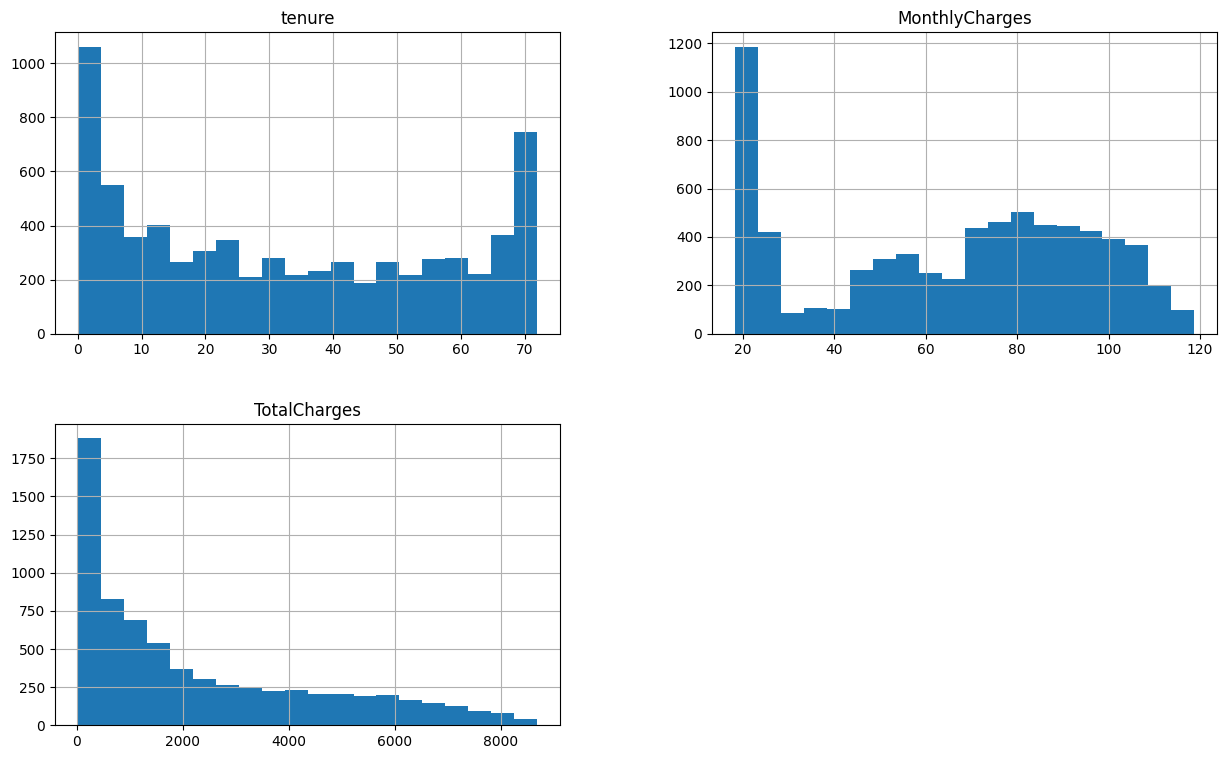

In [66]:
#Plot Histogram to analyze distribution of numerical features
fig = plt.figure(figsize = (15,9))
ax = fig.gca()
df.hist(ax=ax,bins = 20 )

In [ ]:
#Chcekling for oulier in 'tenure' columns

In [64]:
from pyspark.sql.functions import col, sum

# Check for null values in each column
null_counts = data.select([sum(col(column).isNull().cast("int")).alias(column) for column in data.columns])

# Display the null counts for each column
null_counts.show()


+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|         0|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0| 